# Assignment 2

This notebook is the solution to HW2, written by Yaniv Bin and Tair Hakman.

We first would like to import all the required modules in order for our code to run properly:

In [78]:
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
import os.path
from os.path import abspath, dirname, join
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import gzip, string, nltk
from nltk.corpus import conll2002
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics
from gensim.models.keyedvectors import KeyedVectors
from sklearn.naive_bayes import GaussianNB
from sklearn.externals.six.moves import html_parser
from sklearn.externals.six.moves.urllib.request import urlretrieve
from sklearn.datasets import get_data_home
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, f1_score
from collections import Counter
from glob import glob
import re, os, sys, itertools, tarfile
import pandas as pd
from pandas import DataFrame
from collections import Counter
from sklearn.base import TransformerMixin
from sklearn.preprocessing import StandardScaler

## Part 1

Our first task is identifying complex words. In order to do so we will use the data provided. 
first we need to load the data using the provided functions. 
<br>(For a better flow we modified the skeleton code within the notebook, but we added the edit into the skeleton file as well) 

In [4]:
def load_file(data_file):
    words = []
    labels = []   
    with open(data_file, 'rt', encoding="utf8") as f:
        i = 0
        for line in f:
            if i > 0:
                line_split = line[:-1].split("\t")
                words.append(line_split[0].lower())
                labels.append(int(line_split[1]))
            i += 1
    return words, labels

And loading the data:

In [5]:
training_file = abspath(join(dirname("__file__"), "data/complex_words_training.txt"))
development_file = abspath(join(dirname("__file__"), "data/complex_words_development.txt"))
test_file = abspath(join(dirname("__file__"), "data/complex_words_test_unlabeled.txt"))

Now that we have the data we may start working on the actual assignment. 

### Part 1.1 - Evaluation Matrics

Usually in order to evaluate how well a classifcation algorithm works we use three measures - 
- Precision: Measure how 'useful' the results are (how many are hits and how many are miss)
- Recall: Measure how 'complete' the results are (out off all the actually possible results, how many did we hit)
- Fscore: Measure the balance between the Precision and Recall

We would like to implement functions that compose each of these matrics 

We will start by calculating the precision - the precision is defined as:
<br>$precision = \frac{tp}{tp + fp}$
<br>Where $tp$ stands for true-positive meaning a hit, and $fp$ stands for false-positive meaning the prediction is positive but it's actually a false alarm

In [6]:
## Input: y_pred, a list of length n with the predicted labels,
## y_true, a list of length n with the true labels

## Calculates the precision of the predicted labels
def get_precision(y_pred, y_true):
    positive_hits_array = np.array([(1 if(y_pred[i] == y_true[i] == 1) else 0) for i in range(len(y_pred))])
    positive_hits = np.count_nonzero(positive_hits_array == 1)
    total_positive = np.count_nonzero(np.array(y_pred) == 1)
    precision = float(positive_hits) / float(total_positive)
    return precision

In [7]:
y_pred = [0, 1, 1, 0]
y_true = [0, 0, 1, 1]
get_precision(y_pred, y_true)

0.5

The second measure we will implement is the recall, calculated as follows
<br>$recall = \frac{tp}{tp + fn}$
<br>Where $fn$ stands for false-negative, meaning the prediction is negative also it should have been positive(a miss).

In [8]:
## Calculates the recall of the predicted labels
def get_recall(y_pred, y_true):
    positive_hits_array = np.array([(1 if(y_pred[i] == y_true[i] == 1) else 0) for i in range(len(y_pred))])
    positive_hits = np.count_nonzero(positive_hits_array == 1)
    total_positive = np.count_nonzero(np.array(y_true) == 1)
    recall = float(positive_hits) / float(total_positive)
    return recall

In [9]:
y_pred = [0, 1, 1, 0]
y_true = [1, 0, 1, 1]
get_recall(y_pred, y_true)

0.3333333333333333

and the last measure we want to implement is the fscore(also known as f1) which is calculated as:
<br>$F = 2 * \frac{precision*recall}{precision + recall}$
<br> F score measure the relation between the precision and recall, the results vary between 0 and 1, but once it's equal 1 that means the relation is exact meaning the classifier is perfect. 

In [10]:
## Calculates the f-score of the predicted labels
def get_fscore(y_pred, y_true):
    precision = get_precision(y_pred, y_true)
    recall = get_recall(y_pred, y_true)
    fscore = 2 * float(precision * recall) / float(precision + recall)
    return fscore

In [11]:
y_pred = [0, 1, 1, 0]
y_true = [1, 0, 1, 1]
get_fscore(y_pred, y_true)

0.4

For our own good we would also like to implement a function that prints out all the information given the two arrays:

In [12]:
def test_predictions(y_pred, y_true):
    print("Precision:", get_precision(y_pred, y_true))
    print("Recall:", get_recall(y_pred, y_true))
    print("Fscore:", get_fscore(y_pred, y_true))

In [56]:
y_pred = [0, 1, 1, 0]
y_true = [1, 0, 1, 1]
test_predictions(y_pred, y_true)

Precision: 0.5
Recall: 0.3333333333333333
Fscore: 0.4


Now after implementing the functions, we can go on and implement actual classifiers. 

### Part 1.2 - Baselines

#### Part 1.2.1 - All complex

The first classifier we will implement is a very simple one that classifies all the words as complex no matter what they actually are.

In [14]:
## Labels every word complex
def all_complex(data_file):
    words, actual_labels = load_file(data_file)
    all_complex_labels = np.ones((len(words),), dtype=int)
    precision = get_precision(all_complex_labels, actual_labels)
    recall = get_recall(all_complex_labels, actual_labels)
    fscore = get_fscore(all_complex_labels, actual_labels)
    performance = [precision, recall, fscore]
    return performance

And we shall test it with each of the files:

In [15]:
tr_precision, tr_recall, tr_fscore = all_complex(training_file)
print("Training Precision: {} \nTraining Recall: {} \nTraining Fscore: {}".format(tr_precision, tr_recall, tr_fscore))

Training Precision: 0.43275 
Training Recall: 1.0 
Training Fscore: 0.604083057058105


In [16]:
dv_precision, dv_recall, dv_fscore = all_complex(development_file)
print("Dev Precision: {} \nDev Recall: {} \nDev Fscore: {}".format(dv_precision, dv_recall, dv_fscore))

Dev Precision: 0.418 
Dev Recall: 1.0 
Dev Fscore: 0.5895627644569816


One can note how the recall of this model is always 1 - that makes sense because although it probably has a lot of false positives - it never "miss" in terms of false negtive because it's always positive. 

#### Part 1.2.2 - word length

The second baseline we will implement is a word length based one, which gives a positive value to a word if it's length goes past a certain threshold.

In [17]:
### 1.2.2: Word length thresholding
def word_length_baseline(data_file, threshold):
    words, actual_labels = load_file(data_file)
    threshold_labels = [(1 if(len(word) >= threshold) else 0) for word in words]
    
    precision = get_precision(threshold_labels, actual_labels)
    recall = get_recall(threshold_labels, actual_labels)
    fscore = get_fscore(threshold_labels, actual_labels)
    preformance = [precision, recall, fscore]
    return preformance

We want to run this for both the training dataset and the development dataset for different threshold values, and plot this:

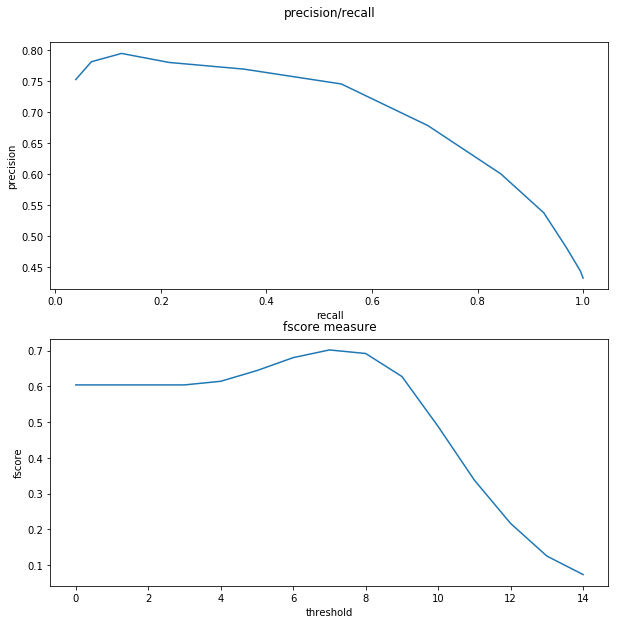

In [89]:
precisions = np.zeros(15)
recall = np.zeros(15)
fscores = np.zeros(15)
for i in range(15):
    tprecision, trecall, tfscore = word_length_baseline(training_file, i)
    precisions[i] = tprecision
    recall[i] = trecall
    fscores[i] = tfscore

plt.figure(num=1, figsize=(10, 10))
pr_plt = plt.subplot(2 ,1, 1, xlabel="recall", ylabel="precision", label="pr")
pr_plt.set_title("precision/recall", y=1.08)
pr_plt.plot(recall, precisions)

fs_plt = plt.subplot(2 ,1, 2, xlabel="threshold", ylabel="fscore", label="fs")
fs_plt.set_title("fscore measure", y=1.01)
fs_plt.plot(range(15), fscores)
plt.show()

We can see that once the recall is big the precision is small and vice versa, that's because the two complement eachother. 

Now we can go about building the "ideal" threshold classifier:

In [20]:
## Finds the best length threshold by f-score, and uses this threshold to
## classify the training and development set
def word_length_threshold(training_file, development_file):
    best_tfscore = 0.0
    best_i = 1
    i = 1
    while(True):
        tprecision, trecall, tfscore = word_length_baseline(training_file, i)
        if(tfscore < best_tfscore):
            break
        else:
            best_i = i
            i += 1
            best_tfscore = tfscore
            
    tprecision, trecall, tfscore = word_length_baseline(training_file, best_i)
    dprecision, drecall, dfscore = word_length_baseline(development_file, best_i)
    training_performance = [tprecision, trecall, tfscore]
    development_performance = [dprecision, drecall, dfscore]
    return training_performance, development_performance

In [65]:
training_performance, development_performance = word_length_threshold(training_file, development_file)
tr_precision, tr_recall, tr_fscore = training_performance
dv_precision, dv_recall, dv_fscore = development_performance
print("Training Precision: {} \nTraining Recall: {} \nTraining Fscore: {}\n".format(tr_precision, tr_recall, tr_fscore))
print("Dev Precision: {} \nDev Recall: {} \nDev Fscore: {}".format(dv_precision, dv_recall, dv_fscore))

Training Precision: 0.6007401315789473 
Training Recall: 0.8440207972270364 
Training Fscore: 0.7018976699495555

Dev Precision: 0.6053511705685619 
Dev Recall: 0.8660287081339713 
Dev Fscore: 0.7125984251968505


#### Part 1.2.3 - Word Frequency 

We now want to implement a method that classifies based on the frequency of a given word in the language, for that we use Google Ngram Counts - so we first have to load it:

In [22]:
### 1.2.3: Word frequency thresholding

## Loads Google NGram counts
def load_ngram_counts(ngram_counts_file): 
    counts = defaultdict(int) 
    with gzip.open(ngram_counts_file, 'rt') as f: 
        for line in f:
            token, count = line.strip().split('\t') 
            if token[0].islower(): 
                counts[token] = int(count) 
    return counts

ngram_path = abspath(join(dirname("__file__"), "data/ngram_counts.txt.gz"))
ngram_counts = load_ngram_counts(ngram_path)

Now that we have it, we can write a code that use thresholding - if the word count of a certain word is lower than the threshold it gives it 0 and otherwise 1

In [23]:
def word_frequency_baseline(data_file, counts, threshold):
    words, actual_labels = load_file(data_file)
    threshold_labels = [(1 if(counts[word] >= threshold) else 0) for word in words]
    
    precision = get_precision(threshold_labels, actual_labels)
    recall = get_recall(threshold_labels, actual_labels)
    fscore = get_fscore(threshold_labels, actual_labels)
    preformance = [precision, recall, fscore]
    return preformance

Now we can test this method using different values for the threshold - We used a range of 30 random numbers between 10 to 2000000 (after examining the Google Ngrams Count) 

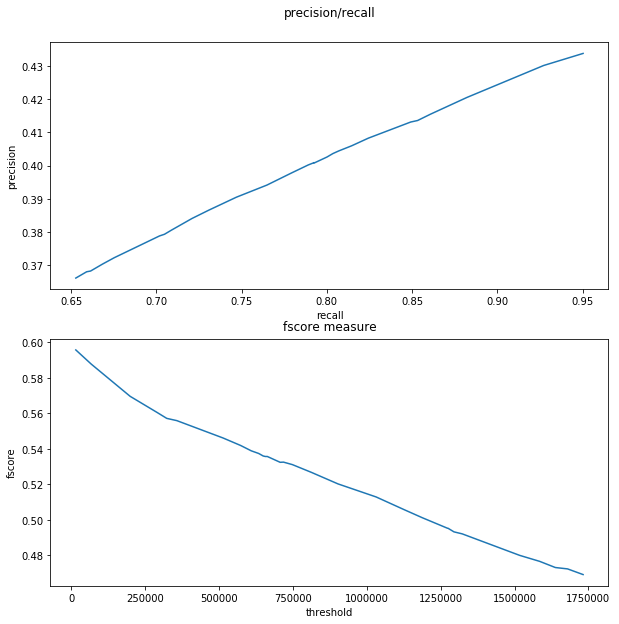

In [88]:
precisions = np.zeros(30)
recall = np.zeros(30)
fscores = np.zeros(30)
thresholds = np.sort(np.random.randint(10, 2000000, size=30, dtype=int))
for i in range(30):
    tprecision, trecall, tfscore = word_frequency_baseline(training_file, ngram_counts, thresholds[i])
    precisions[i] = tprecision
    recall[i] = trecall
    fscores[i]=tfscore

    
plt.figure(num=3, figsize=(10, 10))
pr_plt = plt.subplot(2 ,1, 1, xlabel="recall", ylabel="precision", label="pr")
pr_plt.set_title("precision/recall", y=1.08)
pr_plt.plot(recall, precisions)

fs_plt = plt.subplot(2 ,1, 2, xlabel="threshold", ylabel="fscore", label="fs")
fs_plt.set_title("fscore measure", y=1.01)
fs_plt.plot(thresholds, fscores)
plt.show()

We can see (and it makes sense) that the tresholds can vary the recall and precision - a higher recall will be when the threshold is high, and a lower one when it's low and the exact opposite happens with the precision. We do see once we set the threshold lower we get a better fscore. 

In [25]:
# Finds the best frequency threshold by f-score, and uses this threshold to
## classify the training and development set
def word_frequency_threshold(training_file, development_file, counts):
    best_tfscore = 0.0
    i = 1
    threshold = np.random.randint(10, 2000000, size=1, dtype=int)
    while(True):
        tprecision, trecall, tfscore = word_frequency_baseline(training_file, counts, threshold)
        if(tfscore < best_tfscore):
            break
        else:
            threshold = np.random.randint(10, 2000000, size=1, dtype=int)
            best_tfscore = tfscore
            
    tprecision, trecall, tfscore = word_frequency_baseline(training_file, counts, threshold)
    dprecision, drecall, dfscore = word_frequency_baseline(development_file, counts, threshold)
    
    training_performance = [tprecision, trecall, tfscore]
    development_performance = [dprecision, drecall, dfscore]
    return training_performance, development_performance

In [64]:
training_performance, development_performance = word_frequency_threshold(training_file, development_file, ngram_counts)
tr_precision, tr_recall, tr_fscore = training_performance
dv_precision, dv_recall, dv_fscore = development_performance
print("Training Precision: {} \nTraining Recall: {} \nTraining Fscore: {}\n".format(tr_precision, tr_recall, tr_fscore))
print("Dev Precision: {} \nDev Recall: {} \nDev Fscore: {}".format(dv_precision, dv_recall, dv_fscore))

Training Precision: 0.4063756461803561 
Training Recall: 0.8174465626805315 
Training Fscore: 0.5428735852676002

Dev Precision: 0.3931034482758621 
Dev Recall: 0.8181818181818182 
Dev Fscore: 0.531055900621118


### Part 1.3 - Classifiers

#### Part 1.3.1 - Naive Bayes Classifier

Now that we've tried different baselines and saw the results from them, that were not that great, it's time to do actual classification.
<br>The method we are going to use is called Naive Bayes Classification.

We personally find that explaining this method via an example makes it a bit easier to grasp instead of just overloading people with probability formulas.
<br>We shall use our example on the given problem considering it is most fitting, and afterwards we will implement the actual code.

We have our dataset which is composed of two types of labels - 0 for a simple word, and 1 for a complex word.
Now lets assume (for the sake of the example, the actual dataset might act differently but we shall see later) someone told us the following - there is a 70% chance of a word being simple, and a 30% chance that a word is complexed.
Another thing they tell you is that the mean of the word length of the simple words is 4 and the mean of word length of the complex words is 7.
<br>Now we got a new word, and it has a length of 3, what will we guess it's label is? Well, an educated guess will be to say there's a big chance it's a simple word...

<br>__How did we assume that?__ We saw there is a high chance of being a simple word, and then we also saw the length of the word is 3 and usually shorter words are simple - so by likelihood the chances of our word being simple are pretty high.
<br>The _Naive Bayse Classifier_ works pretty much just like that.

<br>__How exactly does it work__
<br> First thing to note is that the classifier assumes independence among features, this is not always true in real life (actually, it usually isn't...) but it simplifies the model - in our case it will assume there's no relation between the length of a word and it's frequency (although in reallity it's safe to assume a really long word won't be that frequent). 
Because of how wrong this assumption is, the classifier got the name _naive_.

What the classifier does is to find the probability of belonging to a class, given a set of features, in our case we can write it down as $P(simple | f_{length}, f_{freq})$

Once we have that we can use the Bayse rule to get this probabilty:
<br>$P(simple \vert f_{length}, f_{freq}) = \frac{P(simple) * P(f_{length}, f_{freq} \vert simple)}{P(f_{length}, f_{freq})}$

We already know $P(simple)=0.7$ and we don't need $P(f_{length}, f_{freq})$ to build a classifier, so all we are left to do is calculate $P(f_{length}, f_{freq} \vert simple)$ . 

If we apply the conditional probability formula we will get:
<br>$P(f_{length}, f_{freq} \vert simple) = P(f_{length} \vert simple) * P(f_{freq} \vert simple, f_{length})$
<br><br>Or in the general case (not our example) for $n$ features and a label $l$ we get:
<br>$P(f_1, f_2, f_3, \dots , f_n | l) = P(f_1 \vert l) * P(f_2 \vert l, f_1) * \dots * P(f_n \vert l, f_1, \dots, f_{n-1})$

One can note that if we had n features, this will require a lot of data because we will have to have data for each of these assumption, but we don't actually need it. Why? well, this is where the _naive_ part comes in handy - we assumed all features are independent, so what we actually get is:
<br> $P(f_{length}, f_{freq} | simple) = P(f_{length} \vert simple) * P(f_{freq} \vert simple)$
<br><br>Or in the general case:
<br>$P(f_1, f_2, f_3, \dots , f_n \vert l) = \prod{P(f_i|l)}$

So now finally to classify a new vector of features we have to choose the label for it (simple 0 or complex 1), to do so all we have to do is:
<br>
$Classifier(f_{l'}, f_{f'}) = \arg\max_{s\in{0, 1}}P(f_{l'}, f_{f'} \vert s)$ 
<br><br>Or in the general case for $m$ labels and $n$ features:
<br>
$Classifier(f_{1},\dots, f_{n}) = \arg\max_{s\in{0,\dots,m}}P(f_{1},\dots, f_{n} \vert s)$

__implementation__
<br>So now that we get the reasoning behind this method, we can go along and implement the classifier.
<br>One last thing to note is that we were asked to use the Guassian based classifier, this classifier assumes the features follow a _normal_ distribution (meaning all the features falls on a normal curve).

The following code results in the classifier (note the code comments for a step by step explenation):

In [59]:
### 1.3.1: Naive Bayes
        
## Trains a Naive Bayes classifier using length and frequency features
def naive_bayes(training_file, development_file, counts):
    #import training dataset
    t_words, t_labels = load_file(training_file)
    t_features = {}
    # get length features
    t_features["length"] = np.array([len(word) for word in t_words])
    # get frequency features
    t_features["frequency"] = np.array([counts[word] for word in t_words])
    # build features array
    X_t_original = np.array([t_features["length"], t_features["frequency"]]).T
    
    # normalize features
    t_mean = np.mean(X_t_original)
    t_sd = np.std(X_t_original)
    X_t_scaled = (X_t_original - t_mean)/t_sd
    
    # train the classifier
    clf = GaussianNB()
    clf.fit(X_t_scaled, t_labels)
    
    # extract features for development file
    d_words, d_labels = load_file(development_file)
    d_features = {}
    # get length features
    d_features["length"] = np.array([len(word) for word in d_words])
    # get frequency features
    d_features["frequency"] = np.array([counts[word] for word in d_words])
    # build features array
    X_d_original = np.array([d_features["length"], d_features["frequency"]]).T
    
    # normalize development features - note how we use the training mean and sd
    X_d_scaled = (X_d_original - t_mean)/t_sd
    
    dev_pred = clf.predict(X_d_scaled)
    train_pred = clf.predict(X_t_scaled)
    
    tprecision = get_precision(train_pred, t_labels)
    trecall = get_recall(train_pred, t_labels)
    tfscore = get_fscore(train_pred, t_labels)
    
    dprecision = get_precision(dev_pred, d_labels)
    drecall = get_recall(dev_pred, d_labels)
    dfscore = get_fscore(dev_pred, d_labels)
    
    training_performance = [tprecision, trecall, tfscore]
    development_performance = [dprecision, drecall, dfscore]
    return training_performance, development_performance

In [62]:
training_performance, development_performance = naive_bayes(training_file, development_file, ngram_counts)
tr_precision, tr_recall, tr_fscore = training_performance
dv_precision, dv_recall, dv_fscore = development_performance
print("Training Precision: {} \nTraining Recall: {} \nTraining Fscore: {}\n".format(tr_precision, tr_recall, tr_fscore))
print("Dev Precision: {} \nDev Recall: {} \nDev Fscore: {}".format(dv_precision, dv_recall, dv_fscore))

Training Precision: 0.4853700516351119 
Training Recall: 0.9774696707105719 
Training Fscore: 0.6486486486486487

Dev Precision: 0.4610983981693364 
Dev Recall: 0.9641148325358851 
Dev Fscore: 0.6238390092879257


__#TODO__ _add comparision between the classifiers, add more info about each one (the results)_

### Part 1.4 - ambiguity

In some cases the way a words is classified is based on it's context, meaning sometimes a word can be classified as a simple word and sometimes as a difficult word, all because of the context it appeared in. 

We would like to show an example for that - in order to do so, we will find two instances of the same word labeled differently in the training set (the code can easily be adapted to any other set, we chose the training one because it made more sense), then we will explore the context trying to infere why they were tagged differently. 

The first thing we'd like to do is to load the context as well as the words, so we can show how it modifies the classification. In order to do so we need to change the file loading code a bit:

In [ ]:
def load_file_with_context(data_file):
    words = []
    labels = []   
    contexts = []
    with open(data_file, 'rt', encoding="utf8") as f:
        i = 0
        for line in f:
            if i > 0:
                line_split = line[:-1].split("\t")
                words.append(line_split[0].lower())
                labels.append(int(line_split[1]))
                contexts.append(line_split[3])
            i += 1
    return words, labels, contexts

And using the code one the training data we get

In [ ]:
words, labels, contexts = load_file_with_context(training_file)
print(words[0],labels[0],contexts[0])

Now what we need to do is find a words with multiple instances that differ in how it's labeled. 
<br>To do so we will find for each word all it's instances in the words list, and then for words with mulitple labels we will look into the labels to see if they differ, if so we will check the context in which they appear to get a better grasp on why the context matter.

In [ ]:
def find_context_sensitive_words(words, labels, contexts):
    words = np.array(words)
    differences = []
    for word in words:
        ii = np.where(words == word)[0]
        if(len(ii) > 1):
            diff = [(i, j) for i in ii for j in ii if(not labels[i] == labels[j])]
            if(len(diff) > 0):
                # We only have to iterate it half way because the other half is a mirror of the first
                for i in range(int(len(diff)/2)):
                    differences.append((words[diff[i][0]], diff[i][0], diff[i][1]))
    return differences

In [ ]:
ambiguity = find_context_sensitive_words(words, labels, contexts)

And we can show all these words:

In [ ]:
for couple in ambiguity:
    word, index_a, index_b = couple
    print("Word:", word)
    print("Labeled as {} in index {} and as {} in index {}".format(labels[index_a], index_a, labels[index_b], index_b))
    print("First context:\n", contexts[index_a], "\n")
    print( "Second context:\n", contexts[index_b], "\n")

When looking at some of the words one can see how and why they were labeled differently:
- If we look at the word _sprouts_ it appears in two contexts - firstly as a name of a place "Sprouts Farmer" which makes it a very easy identification, but then as a 'sprinkle of sprouts' which is much more complexed (especially if like us you're not a native English speaker and had to google 'sprouts')
- If we look at the word _element_ , seemengly a simple word, it can come as an actual element like in the first context("the heaviest element") but it can also appear in as a slang word - "in his element" like in the second context, which complicate things. 

## Part 2

### Part 2.1

___Remark___ : We did now want to load the entire notebook as part of our notebook because that will just be overloading on our notebook, but we do want to touch upon required information. So we imported the methods we need from the original notebook and implemented methods to fit the requirements of our question.

The first thing we want to do is to explore the dataset they used for the classifiers implementation. In order to do that we will first have to load the dataset(note that we used the code they implemented to do so, but we modified it for our need)

In [2]:
class ReutersParser(html_parser.HTMLParser):
    """Utility class to parse a SGML file and yield documents one at a time."""

    def __init__(self, encoding='latin-1'):
        html_parser.HTMLParser.__init__(self)
        self._reset()
        self.encoding = encoding

    def handle_starttag(self, tag, attrs):
        method = 'start_' + tag
        getattr(self, method, lambda x: None)(attrs)

    def handle_endtag(self, tag):
        method = 'end_' + tag
        getattr(self, method, lambda: None)()

    def _reset(self):
        self.in_title = 0
        self.in_body = 0
        self.in_topics = 0
        self.in_topic_d = 0
        self.title = ""
        self.body = ""
        self.topics = []
        self.topic_d = ""

    def parse(self, fd):
        self.docs = []
        for chunk in fd:
            self.feed(chunk.decode(self.encoding))
            for doc in self.docs:
                yield doc
            self.docs = []
        self.close()

    def handle_data(self, data):
        if self.in_body:
            self.body += data
        elif self.in_title:
            self.title += data
        elif self.in_topic_d:
            self.topic_d += data

    def start_reuters(self, attributes):
        pass

    def end_reuters(self):
        self.body = re.sub(r'\s+', r' ', self.body)
        self.docs.append({'title': self.title,
                          'body': self.body,
                          'topics': self.topics})
        self._reset()

    def start_title(self, attributes):
        self.in_title = 1

    def end_title(self):
        self.in_title = 0

    def start_body(self, attributes):
        self.in_body = 1

    def end_body(self):
        self.in_body = 0

    def start_topics(self, attributes):
        self.in_topics = 1

    def end_topics(self):
        self.in_topics = 0

    def start_d(self, attributes):
        self.in_topic_d = 1

    def end_d(self):
        self.in_topic_d = 0
        self.topics.append(self.topic_d)
        self.topic_d = ""


def stream_reuters_documents(data_path=None):
    DOWNLOAD_URL = ('http://archive.ics.uci.edu/ml/machine-learning-databases/'
                        'reuters21578-mld/reuters21578.tar.gz')
    ARCHIVE_FILENAME = 'reuters21578.tar.gz'
    data_path = os.path.join(get_data_home(), "reuters")
    if not os.path.exists(data_path):
        """Download the dataset."""
        print("downloading dataset (once and for all) into %s" %
              data_path)
        os.mkdir(data_path)

        def progress(blocknum, bs, size):
            total_sz_mb = '%.2f MB' % (size / 1e6)
            current_sz_mb = '%.2f MB' % ((blocknum * bs) / 1e6)
            if _not_in_sphinx():
                sys.stdout.write(
                    '\rdownloaded %s / %s' % (current_sz_mb, total_sz_mb))

        archive_path = os.path.join(data_path, ARCHIVE_FILENAME)
        urlretrieve(DOWNLOAD_URL, filename=archive_path,
                    reporthook=progress)

        print("untarring Reuters dataset...")
        tarfile.open(archive_path, 'r:gz').extractall(data_path)
        print("done.")
          
    parser = ReutersParser()
    doc_counter = 0
#     raw_docs = []
    docs = {
        'title_index': [],
        'title': [],
        'body': [],
        'topic': []
    }
    for filename in glob(os.path.join(data_path, "*.sgm")):
        for doc in parser.parse(open(filename, 'rb')):
            if(doc['topics']):
                for topic in doc['topics']:
                    docs['title_index'].append(doc_counter)
                    docs['title'].append(doc['title'])
                    docs['body'].append(doc['body'])
                    docs['topic'].append(topic)
            else:
                docs['title_index'].append(doc_counter)
                docs['title'].append(doc['title'])
                docs['body'].append(doc['body'])
                docs['topic'].append(None)
            doc_counter += 1
    return docs

What we did is to modify the downloader function to return a dictionary of the form 'title','body', 'topic' which we then can feed into the Pandas dataframe module and explore it.
Note how we arranged it by topics so it will be easier to handle for our needs. 

In [202]:
data_stream = stream_reuters_documents()

In [208]:
df = pd.DataFrame(data=data_stream)
print("there are {} topics in the dataset".format(df.topic.nunique()))
print("and {} unique titles".format(df.title.nunique()))
print("there are {} documents in the dataset".format(df.title_index.nunique()))

there are 445 topics in the dataset
and 20030 unique titles
there are 21578 documents in the dataset


Now for each of the topics we can get the count, mean, max index, std, and so on:

In [207]:
print(df.groupby('topic').describe())

                    title_index                                                \
                          count          mean          std      min       25%   
topic                                                                           
acq                      2448.0  11102.989788  6136.448893      4.0   5398.25   
adb-africa                 10.0   6504.000000  4112.422428   1086.0   3513.00   
adb-asia                   20.0   4519.450000  6073.270622    451.0   1233.75   
afghanistan                 3.0  15466.000000  7466.900562   6844.0  13300.00   
alfonsin                    2.0   7864.500000  4480.935672   4696.0   6280.25   
algeria                    35.0   8099.342857  5928.470535     96.0   3479.00   
alum                       63.0  10444.507937  6873.331391    506.0   3321.00   
amex                       60.0  10376.416667  5634.302229   1361.0   5927.25   
andriessen                  1.0   1365.000000          NaN   1365.0   1365.00   
angola                      

### Part 2.2

In this question, we'll be looking into the task of classifying emails and SMS messages as 'spam' and 'ham' ('ham' being the opposite of spam - good, meaningful messages). We'll be looking and answering questions about pre-written code. The first part of the code loads the data:

In [3]:
def progress(i, end_val, bar_length=50):
    '''
    Print a progress bar of the form: Percent: [#####      ]
    i is the current progress value expected in a range [0..end_val]
    bar_length is the width of the progress bar on the screen.
    '''
    percent = float(i) / end_val
    hashes = '#' * int(round(percent * bar_length))
    spaces = ' ' * (bar_length - len(hashes))
    sys.stdout.write("\rPercent: [{0}] {1}%".format(hashes + spaces, int(round(percent * 100))))
    sys.stdout.flush()

NEWLINE = '\n'
HAM = 'ham'
SPAM = 'spam'

SOURCES = [
    ('data/spam',        SPAM),
    ('data/easy_ham',    HAM),
    ('data/hard_ham',    HAM),
    ('data/beck-s',      HAM),
    ('data/farmer-d',    HAM),
    ('data/kaminski-v',  HAM),
    ('data/kitchen-l',   HAM),
    ('data/lokay-m',     HAM),
    ('data/williams-w3', HAM),
    ('data/BG',          SPAM),
    ('data/GP',          SPAM),
    ('data/SH',          SPAM)
]

SKIP_FILES = {'cmds'}


def read_files(path):
    '''
    Generator of pairs (filename, filecontent)
    for all files below path whose name is not in SKIP_FILES.
    The content of the file is of the form:
        header....
        <emptyline>
        body...
    This skips the headers and returns body only.
    '''
    for root, dir_names, file_names in os.walk(path):
        for path in dir_names:
            read_files(os.path.join(root, path))
        for file_name in file_names:
            if file_name not in SKIP_FILES:
                file_path = os.path.join(root, file_name)
                if os.path.isfile(file_path):
                    past_header, lines = False, []
                    f = open(file_path, encoding="latin-1")
                    for line in f:
                        if past_header:
                            lines.append(line)
                        elif line == NEWLINE:
                            past_header = True
                    f.close()
                    content = NEWLINE.join(lines)
                    yield file_path, content


def build_data_frame(l, path, classification):
    rows = []
    index = []
    for i, (file_name, text) in enumerate(read_files(path)):
        if ((i+l) % 100 == 0):
            progress(i+l, 58910, 50)
        rows.append({'text': text, 'class': classification})
        index.append(file_name)
   
    data_frame = DataFrame(rows, index=index)
    return data_frame, len(rows)

def load_data():
    data = DataFrame({'text': [], 'class': []})
    l = 0
    for path, classification in SOURCES:
        data_frame, nrows = build_data_frame(l, path, classification)
        data = data.append(data_frame)
        l += nrows
    data = data.reindex(np.random.permutation(data.index))
    return data

data = load_data()

Percent: [##################################################] 100%

It's a fancy code, but the imporant thing about it is the data structure: a pandas dataframe in size (D,2) - D being the number of **documents** in the collection. For each document, there are two columns: text (the actual text of the document) and class (classification as ham/spam).

This is the training code (no need to run it yet, just understand how it works):

In [57]:
def build_pipeline():
    pipeline = Pipeline([
        ('count_vectorizer',   CountVectorizer(ngram_range=(1, 2))),
        ('classifier',         MultinomialNB())
    ])
    return pipeline

def train(data = None, n_folds = 6):
    if data is None:
        print("Loading data...")
        data = load_data()
        print("Data loaded")
    k_fold = KFold(n_splits = n_folds)
    pipeline = build_pipeline()
    scores = []
    confusion = numpy.array([[0, 0], [0, 0]])
    print("Training with %d folds" % n_folds)
    for i, (train_indices, test_indices) in enumerate(k_fold.split(data)):
        train_text = data.iloc[train_indices]['text'].values
        train_y = data.iloc[train_indices]['class'].values.astype(str)

        test_text = data.iloc[test_indices]['text'].values
        test_y = data.iloc[test_indices]['class'].values.astype(str)

        print("Training for fold %d" % i)
        pipeline.fit(train_text, train_y)
        print("Testing for fold %d" % i)
        predictions = pipeline.predict(test_text)

        confusion += confusion_matrix(test_y, predictions)
        score = f1_score(test_y, predictions, pos_label=SPAM)
        scores.append(score)
        print("Score for %d: %2.2f" % (i, score))
        print("Confusion matrix for %d: " % i)
        print(confusion)

    print('Total emails classified:', len(data))
    print('Score:', sum(scores)/len(scores))
    print('Confusion matrix:')
    print(confusion)
    return pipeline

A quick overview of how it works:
The code uses a technique called k-fold (cross validation). Instead of simply splitting the corpus to a training and test set, it splits the dataset into k equal parts. The code than runs k times, each time selecting a different part of the corpus as the test set (and the rest k-1 parts as training). So this way, we can use the entire corpus as both training and test set. The disadvantage to this is, of course, performance (the whole learning/predicting process runs k times). 
In this case, we can assume why this technique was used: our corpus is made of several different sources, so simply splitting the corpus would have likely resulted in a test set that isn't similar to the training set.

Another new technique introduced is the pipeline: it is used to create a sequence of several transformers (and a final estimator), and package them all as one object. It does not provide new functionality on it's own, but rather serves as a convinient method to pack a workflow of several transformers.

The first element in the pipeline is the CountVectorizer. It's basic function is simple - it recieves a list of documents, and creates a matrix of documents X token counts. So if a token j appears 4 times in a document i, the matrix value in cell (i,j) will be 4. A token can be an n-gram as well, and we're able to choose an n-gram range, so the Vectorizer is able to mix tokens of different sizes in one matrix. In this example, our n-range is 1-2, meaning we check unigrams and bigrams.

### Part 2.2.1

First let's create the CountVectorizer, and use it to transform our data into a matrix:

In [4]:
cv = CountVectorizer(ngram_range=(1, 2))
data_x, data_y = data['text'], data['class']
X = cv.fit_transform(data_x, data_y)

Note that we're using the entire corpus, with no training/test split, because the k-fold technique ensures that the entire corpus will eventually be used as both training and test data.

First we'll calculate the number of unigrams and bigrams:

In [62]:
def count_uni_bi (fnames):
    cnt = Counter([len(feature.split()) for feature in fnames])
    return {"unigrams": cnt.get(1), "bigrams": cnt.get(2)}

fnames = cv.get_feature_names()
count_uni_bi (fnames)

{'bigrams': 3318380, 'unigrams': 697570}

Since both unigrams and bigrams are used as features (and they're the only features), we could use *get_feature_names* to get the list of all unigrams and bigrams. From here it's just a matter of separating them and counting.

### Part 2.2.2

Now we want to get the most frequent unigrams and bigrams. We could work directly with our matrix, summing every column and printing the top 50 biggest numbers of each n-gram. However, because of the matrix size, we found this to be problematic performance-wise. 
Instead, we would like to recreate the tokens and count ourselves. Luckily, scikit provides easy access to the very same preprocessing methods they use, so we can assure our tokenization methods are identical. We've created a function that splits the data into unigrams and bigrams, and we use the Counter "most_common" method on both.
Not that the bigrams split is also done within a document (meaning the last word of document and the first word of the next document will **not** create a bigram) - this is consistent with the CountVectorizer.

In [64]:
def split_uni_bi (data, analyzer):
    uni, bi = [], []
    for doc in data:
        tokens = analyzer(doc)
        for t in tokens:
            if len(t.split()) == 1:
                uni.append(t)
            else:
                bi.append(t)
    return [uni,bi]

analyzer = cv.build_analyzer()
uni_bi_list = split_uni_bi(data_x, analyzer)

In [68]:
print ("unigrams:")
Counter(uni_bi_list[0]).most_common(50)

unigrams:


[('font', 588020),
 ('3d', 573645),
 ('the', 523545),
 ('br', 506598),
 ('td', 412043),
 ('to', 384631),
 ('and', 304840),
 ('nbsp', 288463),
 ('of', 276364),
 ('http', 240249),
 ('20', 230871),
 ('size', 226011),
 ('tr', 225925),
 ('in', 206212),
 ('width', 197032),
 ('com', 192779),
 ('you', 159126),
 ('face', 153450),
 ('for', 152577),
 ('border', 148637),
 ('is', 147840),
 ('style', 134521),
 ('this', 127919),
 ('align', 127774),
 ('span', 125907),
 ('href', 122468),
 ('height', 122384),
 ('html', 119934),
 ('color', 119523),
 ('www', 116191),
 ('that', 103891),
 ('on', 101327),
 ('your', 96299),
 ('content', 92507),
 ('table', 87217),
 ('with', 86005),
 ('be', 84848),
 ('div', 84766),
 ('arial', 80928),
 ('it', 79414),
 ('from', 76064),
 ('we', 74683),
 ('or', 74405),
 ('center', 73872),
 ('img', 72069),
 ('as', 71809),
 ('enron', 70007),
 ('src', 69740),
 ('are', 69688),
 ('text', 67392)]

In [66]:
print ("bigrams:")
Counter(uni_bi_list[1]).most_common(50)

bigrams:


[('nbsp nbsp', 163936),
 ('br br', 156754),
 ('font size', 111788),
 ('td tr', 108261),
 ('http www', 105357),
 ('font face', 104446),
 ('td td', 98916),
 ('tr td', 90633),
 ('3d http', 83221),
 ('style 3d', 77299),
 ('font td', 68641),
 ('tr tr', 66263),
 ('href 3d', 61747),
 ('font font', 57538),
 ('of the', 55143),
 ('td width', 52193),
 ('color 3d', 50305),
 ('font color', 47765),
 ('img src', 47259),
 ('href http', 47094),
 ('in the', 44708),
 ('arial helvetica', 43463),
 ('width 3d', 43361),
 ('sans serif', 38861),
 ('face 3d', 36805),
 ('size 3d2', 35974),
 ('align center', 35433),
 ('content type', 35306),
 ('helvetica sans', 35306),
 ('bgcolor 3d', 35249),
 ('src http', 33977),
 ('1px solid', 33420),
 ('gif width', 33254),
 ('font family', 33168),
 ('tr table', 31674),
 ('size 3d', 31530),
 ('face 3darial', 31036),
 ('br font', 30866),
 ('face 3dverdana', 30531),
 ('3d font', 30291),
 ('src 3d', 28006),
 ('span style', 27985),
 ('text html', 26424),
 ('face arial', 26149),
 ('

Some of these words look unlikely (they mostly look like HTML documents), but we've verified with the original matrix too. This is a spam dataset, after all.

### Part 2.2.3

For the next task, we'll need the same split but for each class. So we'll filter the dataset per class and use the same method.

In [71]:
ham = data.loc[data['class'] == 'ham']
spam = data.loc[data['class'] == 'spam']
ham_x, spam_x = ham['text'], spam['text']
ham_uni_bi_list = split_uni_bi(ham_x, analyzer)
spam_uni_bi_list = split_uni_bi(spam_x, analyzer)

In [72]:
print ("ham unigrams:")
Counter(ham_uni_bi_list[0]).most_common(50)

ham unigrams:


[('the', 271739),
 ('to', 185712),
 ('and', 123494),
 ('of', 116399),
 ('in', 90256),
 ('com', 71121),
 ('for', 70561),
 ('enron', 70004),
 ('is', 60087),
 ('on', 59190),
 ('http', 58170),
 ('that', 55662),
 ('you', 50956),
 ('td', 46347),
 ('this', 43429),
 ('it', 41292),
 ('with', 39740),
 ('be', 38868),
 ('ect', 38444),
 ('20', 37356),
 ('width', 36024),
 ('have', 33884),
 ('from', 33265),
 ('will', 33164),
 ('www', 32780),
 ('as', 32712),
 ('we', 32597),
 ('at', 31830),
 ('3d', 29716),
 ('are', 29348),
 ('by', 29116),
 ('font', 27064),
 ('or', 25012),
 ('tr', 23382),
 ('if', 22790),
 ('not', 22224),
 ('your', 21613),
 ('br', 21065),
 ('height', 20361),
 ('09', 19971),
 ('src', 19681),
 ('gif', 19436),
 ('img', 19420),
 ('an', 18535),
 ('10', 18144),
 ('hou', 18101),
 ('has', 17889),
 ('was', 17650),
 ('2001', 17145),
 ('href', 16761)]

In [73]:
print ("ham bigrams:")
Counter(ham_uni_bi_list[1]).most_common(50)

ham bigrams:


[('http www', 30946),
 ('of the', 26553),
 ('in the', 21549),
 ('img src', 17425),
 ('hou ect', 17313),
 ('ect ect', 17154),
 ('src http', 15448),
 ('gif width', 14323),
 ('href http', 13703),
 ('to the', 12840),
 ('on the', 12145),
 ('for the', 11875),
 ('09 09', 11240),
 ('td width', 11184),
 ('td tr', 10618),
 ('td td', 10294),
 ('will be', 10226),
 ('cnet com', 9924),
 ('com gif', 9873),
 ('if you', 9428),
 ('to be', 8192),
 ('tr td', 7881),
 ('com click', 7810),
 ('width height', 7550),
 ('enron enron', 7479),
 ('online com', 7399),
 ('http clickthru', 7398),
 ('clickthru online', 7354),
 ('font face', 7349),
 ('enron com', 6858),
 ('with the', 6778),
 ('the company', 6738),
 ('and the', 6524),
 ('pm to', 6131),
 ('at the', 5962),
 ('3d http', 5788),
 ('zdnet com', 5605),
 ('www cnet', 5539),
 ('you have', 5478),
 ('tr table', 5447),
 ('that the', 5418),
 ('www zdnet', 5253),
 ('arial helvetica', 5069),
 ('width 3d', 4999),
 ('height td', 4917),
 ('am to', 4798),
 ('message from',

In [74]:
print ("spam unigrams:")
Counter(spam_uni_bi_list[0]).most_common(50)

spam unigrams:


[('font', 560956),
 ('3d', 543929),
 ('br', 485533),
 ('td', 365696),
 ('nbsp', 278903),
 ('the', 251806),
 ('size', 213214),
 ('tr', 202543),
 ('to', 198919),
 ('20', 193515),
 ('http', 182079),
 ('and', 181346),
 ('width', 161008),
 ('of', 159965),
 ('face', 144363),
 ('border', 133328),
 ('style', 131069),
 ('span', 124769),
 ('align', 123644),
 ('com', 121658),
 ('in', 115956),
 ('color', 113473),
 ('html', 112620),
 ('you', 108170),
 ('href', 105707),
 ('height', 102023),
 ('content', 89698),
 ('is', 87753),
 ('this', 84490),
 ('www', 83411),
 ('div', 82954),
 ('for', 82016),
 ('your', 74686),
 ('arial', 73977),
 ('table', 73719),
 ('center', 70018),
 ('text', 63758),
 ('img', 52649),
 ('class', 51690),
 ('body', 51559),
 ('src', 50059),
 ('strong', 50059),
 ('or', 49393),
 ('3d2', 49029),
 ('3d0', 48932),
 ('that', 48229),
 ('type', 47829),
 ('with', 46265),
 ('be', 45980),
 ('bgcolor', 45055)]

In [75]:
print ("spam bigrams:")
Counter(spam_uni_bi_list[1]).most_common(50)

spam bigrams:


[('nbsp nbsp', 161630),
 ('br br', 155432),
 ('font size', 107762),
 ('td tr', 97643),
 ('font face', 97097),
 ('td td', 88622),
 ('tr td', 82752),
 ('3d http', 77433),
 ('style 3d', 76837),
 ('http www', 74411),
 ('font td', 64005),
 ('tr tr', 61843),
 ('href 3d', 59828),
 ('font font', 55922),
 ('color 3d', 49814),
 ('font color', 46183),
 ('td width', 41009),
 ('arial helvetica', 38394),
 ('width 3d', 38362),
 ('face 3d', 35937),
 ('size 3d2', 35712),
 ('sans serif', 35613),
 ('content type', 34595),
 ('align center', 34124),
 ('helvetica sans', 33665),
 ('1px solid', 33420),
 ('href http', 33391),
 ('bgcolor 3d', 33067),
 ('font family', 32091),
 ('face 3darial', 30773),
 ('size 3d', 30654),
 ('face 3dverdana', 30419),
 ('3d font', 30038),
 ('img src', 29834),
 ('of the', 28590),
 ('br font', 27848),
 ('span style', 27816),
 ('tr table', 26227),
 ('text html', 26213),
 ('align 3d', 25160),
 ('size 3d1', 24888),
 ('td align', 24565),
 ('src 3d', 24095),
 ('body html', 23957),
 ('htm

### Part 2.2.4

Now we need to find the top 20 features for each class. Scikit offers a solution for this case - SelectFromModel. However, we ran into two problems when trying to use it:
-SelectFromModel does not support sparse matrices (and our matrix is way too big to not be sparse)
-More importantly - for binary classification tasks, SelectFromModel can only returns one list of top features (and not a feature for each class).

We've had to dig deeper, and when we checked the source code, we discovered that SelectFromModel basically just returns the features with the highest coefficient (more specifically, highest absolute value of coefficient). So we've decided to work with the coefficient ourselves. So first, let's get our data:

In [6]:
train_text = data_x[:49092]
train_y = data_y[:49092]
X = cv.fit_transform(train_text)
mnb = MultinomialNB().fit (X, train_y)
coefs = mnb.coef_[0]

Note: this time we do split to train and testing data, but we only split once in the 'normal' method, without using cross-validation.

We have our coefficient list, but we still run into the same problem - we only have a general list for the classifier, and not for each category. At first we thought that each side end of the list represents a different class (so the top 20 features will be class A, and the bottom 20 class B). But upon further inspection, this turned out to be wrong. We looked at the "feature count" attribute of each feature - which represents the number of samples encountered for each (class, feature) during fitting.
The bottom 20 looked pretty good:

In [9]:
feature_names = cv.get_feature_names()
args = np.argsort(coefs)
top_20, bottom_20 = args[:20], args[-20:]
bottom = [feature_names[i] for i in bottom_20]
print ("bottom 20:")
for i in range(20):
    print (bottom[i], mnb.feature_count_[0][bottom_20[i]], mnb.feature_count_[1][bottom_20[i]])

bottom 20:
span 892.0 103857.0
style 2841.0 109185.0
border 12274.0 112371.0
face 7149.0 120328.0
nbsp nbsp 1841.0 126069.0
br br 981.0 130330.0
of 95416.0 134255.0
width 28520.0 134460.0
http 48367.0 151916.0
and 101123.0 151991.0
20 30429.0 160500.0
to 152782.0 166070.0
tr 18935.0 167658.0
size 10019.0 177519.0
the 223453.0 210599.0
nbsp 7915.0 223793.0
td 37049.0 304758.0
br 16502.0 404666.0
3d 25924.0 453196.0
font 21119.0 467026.0


But the top 20, on the other hand:

In [10]:
top = [feature_names[i] for i in top_20]
print ("top 20:")
for i in range(20):
    print (top[i], mnb.feature_count_[0][top_20[i]], mnb.feature_count_[1][top_20[i]])

top 20:
further improvments 1.0 0.0
grew 151 1.0 0.0
grew 150 1.0 0.0
grew 12 1.0 0.0
gretna va 3.0 0.0
gretna 3.0 0.0
gretchen sprocket 1.0 0.0
gretchen oddly 2.0 0.0
gretchen morgenson 1.0 0.0
gretchen matt 2.0 0.0
gretchen marshall 1.0 0.0
gretchen mahajan 1.0 0.0
gretchen lotz 1.0 0.0
gretchen jennings 2.0 0.0
gretchen is 1.0 0.0
gretchen invited 1.0 0.0
gretchen hansen 1.0 0.0
gretchen am 1.0 0.0
greta tom 2.0 0.0
greta toc 1.0 0.0


As you can see, all those features have extremely small feature counts - which means they are extremely rare, and not valuable features. 
This explains why Scikit used the top **absolute values** of coefficients - all our coefficients are negative numbers, and here we see that the bottom negative numbers are the valueable ones - hence, the one who have the highest absolute value.
Also, inspecting Scikit's code and documentation, nowhere does it implies there's any use to the worst coefficients (for example, SelectFromModel throws them away beneath a certain threshold). 

So, the coefficient list on it's own doesn't solve our problem - we had to dig even deeper. We discovered a curious thing: when we checked coeff for other classification tasks, with more than one class, coeff actually returned a separate list for every class. Only in binary tasks, coeff returns only one list. So we looked into Naive Bayes code to discover what are those coefficient values, and this is what we found:

def _get_coef(self):
    return (self.feature_log_prob_[1:]
            if len(self.classes_) == 2 else self.feature_log_prob_)
            
(this is a quote from Scikit's code, so we can't run it here).

We disover that the coefficient is nothing more than the log probability of every feature. And also, it seems that for some reason, for binary tasks, Scikit decides specifically to only return the coefficients for the first class. But luckily, we can still access the original log probabilities, and get both lists. We just have to check which class is 0, and which is 1:

In [11]:
mnb.classes_

array(['ham', 'spam'], dtype='<U4')

So we just have to access the bottom 20 (or top 20 absolute values) features of every list:

In [18]:
ham_coeffs = mnb.feature_log_prob_[0]
spam_coeffs = mnb.feature_log_prob_[1]

def print_bottom_names (coeffs, feature_names,n, class_num):
    args = np.argsort(coeffs)
    bottom_co = args[-n:]
    bottom = [feature_names[i] for i in bottom_co]
    for i in range(n):
        print (bottom[i], mnb.feature_count_[class_num][bottom_co[i]])
        
print ("top features for ham:")
print_bottom_names(ham_coeffs, feature_names, 20, 0)

print()
print ("top features for spam:")
print_bottom_names(spam_coeffs, feature_names, 20, 1)

top features for ham:
20 30429.0
be 31798.0
with 32565.0
ect 32565.0
it 33844.0
this 35647.0
td 37049.0
you 42073.0
that 46028.0
http 48367.0
on 48744.0
is 49247.0
enron 57919.0
for 57988.0
com 58348.0
in 74138.0
of 95416.0
and 101123.0
to 152782.0
the 223453.0

top features for spam:
span 103857.0
style 109185.0
border 112371.0
face 120328.0
nbsp nbsp 126069.0
br br 130330.0
of 134255.0
width 134460.0
http 151916.0
and 151991.0
20 160500.0
to 166070.0
tr 167658.0
size 177519.0
the 210599.0
nbsp 223793.0
td 304758.0
br 404666.0
3d 453196.0
font 467026.0


So our results know makes perfect sense - we see that "ham" words are generally pretty normal ("be", "with" etc) while "spam" words are generally more nonsense. Each word also have very high feature count for its class.

### Part 2.2.5

So now we want to add another feature to our model - the length of the text. But we should consider that the new feature is usually on a completely different scale to our normal features. The length of most documents is thousands of characters, While our usual features (number of appearences for a certain word/bigram in a document) is much lower. Is this a problem?

Let's return to the way Naive Bayes classifier works, as explained in part 1:
-We assume the features are independent
-We calculate the probability of belonging to a specific class:
<br>$P(f_1, f_2, f_3, \dots , f_n \vert l) = \prod{P(f_i|l)}$

As we can see, the probability for each feature is calculated separately and independently, and eventually we multiply all those probabilities. Because of that, the scale of the feature doesn't make a difference. Handling of each feature is independent, and by the time we multiply them, they're all converted to probabilities (which are of course scaled between 0-1).

What about Logistic Regression? 
Well, first we have to understand how it works. Logistic Regression is similar to Linear Regression (like we implemented in homework1, question 2). The main difference is that while we now wish to use it for binary classification tasks (while linear regression predicted the y value, but not a binary value). So instead, we use the Sigmoid Function to normalize our predicted values between 0 and 1.

(add sigmoid function here)

Logistic regression, on it's own, does not require scaling. The reason is that after repeated iterations, the optimal coefficients for each feature are chosen, and those coefficients take into account the scale of the feature. That's not to say scaling is useless. Many optimization algorithms (such as gradient descent) converges faster on normalized values, meaning that scaling will lead to better performance. But it isn't neccesary.

So when is scaling neccesary?
If we're using a Logistic Regression model **with regularization**. Certain penalty functions are very sensitive to scaling, meaning that using the same feature but in different scale (for example, using meters or kilometers) will result in drastically different penalties. The Logistic Regression used in the model uses the solver 'lbfgs', which according to Scikit documentation, only works with the L2 penalty function:

(add L2 penalty function)

This function is sensitive to scaling. So in order to use this length feature in the Logistic Regression model, we'll need to scale it - but not because of the Logistic Regression itself, but because of the regularization method it uses.

### Part 2.2.6

So let's add the length feature to our model. We will build our own Pipeline, and we'll also use FeatureUnion. FeatureUnion concatenates lists of features from different transformers. Meaning we can "prepeare" several feature sets separately (running each one through different transformers), and use the FeatureUnion to combine them to a single feature list.

The FeatureUnion and the Pipeline accept objects called transformers. Transformers in Scikit are objects who inherit from general class TransformerMixin, and implement two methods: fit and transform. In our case, we will build a very simple transformer that returns the length of each string:

In [73]:
class LengthTransformer(TransformerMixin):
    def transform(self, X, **transform_params):
        return np.array([len(doc) for doc in X]).reshape(-1,1)

    def fit(self, X, y=None, **fit_params):
        return self 

As you can see, our fit method does nothing (as there's no need to fit the data in any way). Our transform method, at it's core, returns the length of every item in the training set. It also prepears the datat for the scaler - by converting it into a numpy array, and reshaping it (as the scaler does not accept 1D arrays).
Now here's our FeatureUnion:

In [80]:
union = FeatureUnion([
                ("count", CountVectorizer(ngram_range=(1, 2))), 
                ("length", Pipeline([("lt", LengthTransformer()), ("scaler", StandardScaler(with_mean=False))]))])

We merge two feature sets - the "count' feature set is the CountVectorizer from eariler, while the "length" feature set is our newly written length transformer. We normalize the length, for reasons we explained in the previous question.

So here's our complete pipeline:

In [81]:
def build_pipeline2():
    pipeline = Pipeline([
        ('features',   FeatureUnion([
                ("count", CountVectorizer(ngram_range=(1, 2))), 
                ("length", Pipeline([("lt", LengthTransformer()), ("scaler", StandardScaler(with_mean=False))]))])), 
        ('classifier',         LogisticRegression(solver='lbfgs'))
    ])
    return pipeline

And now let's run the original code, with our pipeline:

In [82]:
def train2(data = None, n_folds = 4):
    if data is None:
        print("Loading data...")
        data = load_data()
        print("Data loaded")
    k_fold = KFold(n_splits = n_folds)
    pipeline = build_pipeline2()
    scores = []
    confusion = np.array([[0, 0], [0, 0]])
    print("Training with %d folds" % n_folds)
    for i, (train_indices, test_indices) in enumerate(k_fold.split(data)):
        train_text = data.iloc[train_indices]['text'].values
        train_y = data.iloc[train_indices]['class'].values.astype(str)
        test_text = data.iloc[test_indices]['text'].values
        test_y = data.iloc[test_indices]['class'].values.astype(str)
        
        print("Training for fold %d" % i)
        pipeline.fit(train_text, train_y)
        print("Testing for fold %d" % i)
        predictions = pipeline.predict(test_text)
        
        confusion += confusion_matrix(test_y, predictions)
        score = f1_score(test_y, predictions, pos_label=SPAM)
        scores.append(score)
        
        print("Score for %d: %2.2f" % (i, score))
        print("Confusion matrix for %d: " % i)
        print(confusion)

    print('Total emails classified:', len(data))
    print('Score:', sum(scores)/len(scores))
    print('Confusion matrix:')
    print(confusion)
    return pipeline
    confusion = confusion_matrix(test_y, predictions)
    score = f1_score(test_y, predictions, pos_label=SPAM)
    print("Score for %d: %2.2f" % (i, score))
    print("Confusion matrix for %d: " % i)
    print(confusion)
    print('Total emails classified:', len(test_text))
    return pipeline

pipeline = train2(data)

Training with 4 folds
Training for fold 0
Testing for fold 0
Score for 0: 1.00
Confusion matrix for 0: 
[[5822   28]
 [  53 8825]]
Training for fold 1
Testing for fold 1
Score for 1: 0.99
Confusion matrix for 1: 
[[11625    65]
 [  106 17660]]
Training for fold 2
Testing for fold 2
Score for 2: 0.99
Confusion matrix for 2: 
[[17446   106]
 [  167 26464]]
Training for fold 3
Testing for fold 3
Score for 3: 1.00
Confusion matrix for 3: 
[[23397   142]
 [  208 35163]]
Total emails classified: 58910
Score: 0.9950496023828033
Confusion matrix:
[[23397   142]
 [  208 35163]]


## Part 3

In this task, we will create a NER (Named Entity Recognition) model that recognizes names of persons, organizations and other entities in text. We will use the CoNLL 2002 dataset. As we build the code, we will use the Spanish version of the dataset. At the end of every segment, we'll test our functions on the Dutch dataset and compare the differences. 
First, we will import the data:

In [50]:
etr = conll2002.chunked_sents('esp.train') # In Spanish

Note that our data, as presented in the assignment, comes in the form of **chunked_sents**. This is a tree data structure, that represent the data like this:

-A word is represented as a pair (word, POS tagging).
-Each sentence is a tree. The root of the tree is always "S".
-The words of the sentence are the children of the root, depending on their NER tag:
For NER tag O, the word itself (represented by a pair) will be a direct children of the root. 
For other tags, the children will be another subtree. His root will be the category (for example, "LOCATION"), and his children will be all the words within the LOCATION tag.

This representation is equivalent to a list, and we can easily convert between the two. It does have one advantage over lists - the tree structure "forces" legal tag sequences by its nature, and it's impossible to represent an illegal sequence using a tree. Nevertheless, for our questions we will use the list form, for several reasons:

-The chunked_sents represnatation doesn't directly include the word tags we need.
-Scikit provides a much wider toolkit for lists rather than trees, including the models we were asked to use (such as DictVectorizer).
-Working with a list is much more simpler and convinient.
We'll refer to the question of illegal sequences later on.

So here is our lists:

In [12]:
train_sents = list(conll2002.iob_sents('esp.train'))
test_sents = list(conll2002.iob_sents('esp.testa'))
d_train_sents = list(conll2002.iob_sents('ned.train'))
d_test_sents = list(conll2002.iob_sents('ned.testa'))

Let's understand how our dataset is represented. For example, let's look at an example of the first element (and hence, first sentence) in the first dataset: 

In [4]:
train_sents[0]

[('Melbourne', 'NP', 'B-LOC'),
 ('(', 'Fpa', 'O'),
 ('Australia', 'NP', 'B-LOC'),
 (')', 'Fpt', 'O'),
 (',', 'Fc', 'O'),
 ('25', 'Z', 'O'),
 ('may', 'NC', 'O'),
 ('(', 'Fpa', 'O'),
 ('EFE', 'NC', 'B-ORG'),
 (')', 'Fpt', 'O'),
 ('.', 'Fp', 'O')]

As we can see:

-A word is represented by a tuple of three elements: the word itself, it's POS (Part of Speech) tagging, and it's correct NER tagging.
-A sentence is represented by a list of words
-Each element in the dataset is a sentence.

Now that we understand our data, it's time to extract features. We'll be looking for word level features, and in this step we'll be looking at each word separately. Those are the features we've chosen to extract for every word:

Form (The actual word), POS tagging, is number, does it contain a number, does it begin with a capital letter, is it all capital letters, is it a punctuation char, the first one, two and three letters of the word, the last one, two and three letters in of the word. 
Here's the code for feature extraction:

In [21]:
def hasNumbers(str):
    return any(c.isdigit() for c in str)

def get_word_features (word):
    w = word[0]
    features = {
     "form": w,
     "pos": word[1],
     "is_number": w.isdigit(),
     "contains_number": hasNumbers(w),
     "beginCapital": w[0].isupper(),
     "allCaps": w.isupper(),
     "isPunc": w in string.punctuation,
     "firstLetter": w[0],
     "first2Letters": w[0:2],
     "first3Letters": w[0:3],
     "lastLetter": w[-1],
     "last2Letters": w[-2:],
     "last3Letters": w[-3:]
    }
    return features

And here's an example on the word 'Melbourne':

In [6]:
get_word_features(train_sents[0][0])

{'allCaps': False,
 'beginCapital': True,
 'contains_number': False,
 'first2Letters': 'Me',
 'first3Letters': 'Mel',
 'firstLetter': 'M',
 'form': 'Melbourne',
 'isPunc': False,
 'is_number': False,
 'last2Letters': 'ne',
 'last3Letters': 'rne',
 'lastLetter': 'e',
 'pos': 'NP'}

So now we have our features, it's time to train our model. We will be using Scikit's DictVectorizer data structure to keep our data, and it's logistic regression implementation for the training. Those methods requires two seperate lists of identical size, where every element represents one word in the corpus. The first list (X) keeps the list of features for every word, and the second list (y) has the NER tagging of the word - which is the answer our model will be trying to guess.

Here is the code that creates those lists:

In [15]:
def get_corpus_features (corpus):
#gets a corpus, returns a list of features for every word
    X=[]
    for sent in corpus:
        X+=[get_word_features(w) for w in sent]
    return X

def get_y (corpus):
    y=[]
    for sent in corpus:
        y+=[w[2] for w in sent]
    return y

Note that, in addition to the obvious effect of getting features/NER taggings, those functions also transform our data from a list of **sentences** to a list of **words** - so our output is a big list of all the words, not divided to sentences anymore.

Now we'll create our DictVectorizer and train our model:

In [22]:
def train(train_sents, v, features):
    y = get_y (train_sents)
    X = v.fit_transform(features)
    clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(X, y)
    return clf

v = DictVectorizer(sparse=True)
features = get_corpus_features(train_sents)
clf = train(train_sents, v, features)

The **DictVecotizer** structure and it's fit_transform method, transforms the features list to a matrix. Each row in the matrix represents a word, and each column represents a feature. Each cell M(i,j) includes the corresponding numerical value for feature j in word i.

But what if the features are non-numerical? Boolean data easily transforms to 1 (True) or 0 (False), but strings are a bit more complicated to encode. DictVectorizer's solution is to create a separate boolean feature for every string it encounters. For example, for the word "Melbourne", rather than the "firstLetter" feature, it will create a new boolean feature: "firstLetter=M", that will be True for every word that begins in M, and False otherwise. This is similar to a One-Hot Encoding vector.

This is a good solution, but it means that for each possible value of a string feature (for example, each word, prefix or suffix of length 1,2,3), a specific feature will be created. In other words, our matrix is getting really big. For the first sentence alone (11 words), 75 features are created. For the entire dataset (264715 words), the matrix will be huge - in fact, too huge for the computer's memory (or at least, *my* computer's memory) to handle.

That's why we use a **sparse** version of the matrix. How do this work? The crucial fact is that while we have a lot of data, mthe huge majority of it (typically above 99%) is zeros. For example, the word "Melbourne" will recieve 1 in the "firstLetter=M" feature, and 0 in every other "firstLetter" feature. The same applies for every single string feature (some of them, such as 3 letter combinations, have a lot of possible values) - that's a lot of zeros.
So the sparse data structre take advantage of that fact. Rather than actually save all those zeros, it only keeps the non-zero values and their positions, and assumes zero everywhere else. 

So now we have our sparse matrix X, and our target values y, it's time to create our classifier (clf) using Scikit's logistic regression implementation. It's time to test this model on the our test set:

In [23]:
def predict (clf, v, test_features):
    X2 = v.transform(test_features)
    return clf.predict(X2)

test_features = get_corpus_features(test_sents)
y_predict = predict (clf, v, test_features)
y_true = get_y (test_sents)

This function is fairly straight forward, but it's interesting to note the *transform* method used. We create a sparse feature matrix for the test set, but it will not be in the same size as the original matrix for the train data. However, the *predict* method demands that the train and test matrixes will have the same number of features. 
The transform method transforms the test_features matrix to the same size as the train_features - by adding empty columns for features encountered in the training data, but not the test data. However, this also means there's some information loss - as features that were encountered in the test data but not the train data are "silently ignored".

So now we have our predictions, it's time to evaluate how well we did. We can do this by several different methods. The easiest of which will be to calculate the accuracy score:

In [24]:
def accuracy (x,y):
    correct = sum([1 if x[i]==y[i] else 0 for i in range(len(x))])
    return correct / len(x)

accuracy(y_predict, y_true)

0.9295391417720084

So almost 93%, not too bad but we will try to do better. We also have more tools to analyze our errors. For a start, we can simply print all the errors and manually look at them:

In [23]:
def get_errors (x,y,test_sents):
    features = get_corpus_features(test_sents)
    errors=[]
    for i in range(len(x)):
        if x[i]!=y[i]:
            errors.append((y[i], x[i], features[i].get("form")))
    return sorted(errors)
        
errors = get_errors (y_predict,y_true,test_sents)
for i in range(20):
    print('correct=%-8s guess=%-8s word=%-30s' % (errors[i][0],errors[i][1],errors[i][2]))
    
#we only print the first 20 errors as examples

correct=B-LOC    guess=B-MISC   word=K-2                           
correct=B-LOC    guess=B-MISC   word=K-2                           
correct=B-LOC    guess=B-MISC   word=K-2                           
correct=B-LOC    guess=B-MISC   word=K-2                           
correct=B-LOC    guess=B-MISC   word=MADRID                        
correct=B-LOC    guess=B-MISC   word=Región                        
correct=B-LOC    guess=B-MISC   word=SEVILLA                       
correct=B-LOC    guess=B-MISC   word=SEVILLA                       
correct=B-LOC    guess=B-MISC   word=Tíbet                         
correct=B-LOC    guess=B-MISC   word=Yacuiba-Río                   
correct=B-LOC    guess=B-ORG    word=ACEUCHAL                      
correct=B-LOC    guess=B-ORG    word=Aceuchal                      
correct=B-LOC    guess=B-ORG    word=Auditorio                     
correct=B-LOC    guess=B-ORG    word=Austria                       
correct=B-LOC    guess=B-ORG    word=Autoridad  

We can also take a look at the confusion matrix:
(We'll also print the NER tags in order, because the Scikit confusion matrix does not include labels).

In [12]:
print (set(y_true))
print (metrics.confusion_matrix(y_true, y_predict))

{'I-PER', 'B-ORG', 'I-LOC', 'B-PER', 'B-MISC', 'B-LOC', 'I-MISC', 'O', 'I-ORG'}
[[  779    10    77    30     3     5    30    15    35]
 [   17   214    42     8     0    32    26    14    92]
 [  186    45  1201    67     1    12    52    53    83]
 [  107     5    49   739    20    11    25   233    33]
 [   24     5     9    30   131     5    37    18    78]
 [   51    33    34    21    12   126    55    29   293]
 [  159    53   121    41    18    68   382    78   446]
 [   83     5    36   142    12    12    25   477    67]
 [    7    35    72    17     1    35    35     9 45145]]


Scikit also offers an handy tool called a classification report:

In [13]:
print(metrics.classification_report(y_true, y_predict))

             precision    recall  f1-score   support

      B-LOC       0.55      0.79      0.65       984
     B-MISC       0.53      0.48      0.50       445
      B-ORG       0.73      0.71      0.72      1700
      B-PER       0.67      0.60      0.64      1222
      I-LOC       0.66      0.39      0.49       337
     I-MISC       0.41      0.19      0.26       654
      I-ORG       0.57      0.28      0.38      1366
      I-PER       0.52      0.56      0.53       859
          O       0.98      1.00      0.99     45356

avg / total       0.92      0.93      0.92     52923



It seems we are doing a very good job with recognizing O's, but we struggle with other tags. In general, B tags seem to have better score than I tags, while MISC category seems to be the most difficult to classify. It also means that our 93% accuracy score is misleading - the score is relatively high because we are good in recognizing O's (which is the majority of the dataset), but when it comes to the classification of other tags, our accuracy is much lower.

Let's check our model on the Dutch dataset as well:

In [14]:
d_features = get_corpus_features(d_train_sents)
d_clf = train(d_train_sents, v, d_features)
d_test_features = get_corpus_features(d_test_sents)
d_y_predict = predict (d_clf, v, d_test_features)
d_y_true = get_y (d_test_sents)
print ("accuracy:", accuracy (d_y_predict,d_y_true))
print (metrics.classification_report(d_y_true, d_y_predict))

accuracy: 0.9508053174834824
             precision    recall  f1-score   support

      B-LOC       0.65      0.60      0.62       479
     B-MISC       0.74      0.60      0.66       748
      B-ORG       0.72      0.45      0.55       686
      B-PER       0.55      0.70      0.62       703
      I-LOC       0.37      0.23      0.29        64
     I-MISC       0.42      0.23      0.30       215
      I-ORG       0.69      0.37      0.48       396
      I-PER       0.38      0.45      0.41       423
          O       0.98      1.00      0.99     33973

avg / total       0.95      0.95      0.95     37687



It seems our Dutch model is doing slightly better than the Spanish one, but it's still prone to similar mistakes - once again we recognize very high success rates among O's (which are the big majority of the dataset), I tags are more difficult to predict than B tags, and "Misc" category is still problematic. 
One noticeable difference is that the Dutch model seems to struggle with Location names (0.29 fscore on I-LOC - even lower than I-MISC), which the Spanish model did better on. A possible explanation is insufficient training data - the Dutch dataset only had 64 I-LOC tags, which is much lower than other tags. 
The support column refers to the test dataset and not the training dataset, but a check on the training dataset confirms that I-LOC tags are indeed relatively rare.

So now, we will try to imrove our overall model by using more than just word-specific features - we'll be looking at features of the previous and following word. Here's our updated *get_word_features2* method, which now receives three arguments (the previous and next word, in addition to the current one) and extracts all features for all 3 words: 

In [15]:
def get_word_features2 (word, prev, next):
#also includes information about next and previous word
    w = word[0]
    p = prev[0]
    n = next[0]
    features = {
     "form": w,
     "pos": word[1],
     "is_number": w.isdigit(),
     "contains_number": hasNumbers(w),
     "beginCapital": w[0].isupper(),
     "allCaps": w.isupper(),
     "isPunc": w in string.punctuation,
     "firstLetter": w[0],
     "first2Letters": w[0:2],
     "first3Letters": w[0:3],
     "lastLetter": w[-1],
     "last2Letters": w[-2:],
     "last3Letters": w[-3:],
     "p_form": p,
     "p_pos": prev[1],
     "p_is_number": p.isdigit(),
     "p_contains_number": hasNumbers(p),
     "p_beginCapital": p[0].isupper(),
     "p_allCaps": p.isupper(),
     "p_isPunc": p in string.punctuation,
     "p_firstLetter": p[0],
     "p_first2Letters": p[0:2],
     "p_first3Letters": p[0:3],
     "p_lastLetter": p[-1],
     "p_last2Letters": p[-2:],
     "p_last3Letters": p[-3:],
     "n_form": n,
     "n_pos": next[1],
     "n_is_number": n.isdigit(),
     "n_contains_number": hasNumbers(n),
     "n_beginCapital": n[0].isupper(),
     "n_allCaps": n.isupper(),
     "n_ispunc": n in string.punctuation,
     "n_firstLetter": n[0],
     "n_first2Letters": n[0:2],
     "n_first3Letters": n[0:3],
     "n_lastLetter": n[-1],
     "n_last2Letters": n[-2:],
     "n_last3Letters": n[-3:]
    }
    return features

def get_corpus_features2 (corpus):
#gets a corpus, returns a list of features for every word
    flat = [w for sent in corpus for w in sent]
    pad = [("*","*","*")]
    flat = pad + flat + pad
    X=[]
    for i in range(1, len(flat)-1):
        X.append(get_word_features2(flat[i],flat[i-1],flat[i+1]))
    return X

So now let's train on the new data, and try to predict and check our new accuracy score:

In [17]:
features2 = get_corpus_features2(train_sents)
clf2 = train(train_sents, v, features2)
test_features2 = get_corpus_features2(test_sents)
y_predict2 = predict (clf2, v, test_features2)
y_true2 = get_y (test_sents)
print ("accuracy:", accuracy (y_predict2,y_true2))
print (metrics.classification_report(y_true2, y_predict2))

accuracy: 0.9528560361279594
             precision    recall  f1-score   support

      B-LOC       0.59      0.79      0.68       984
     B-MISC       0.53      0.50      0.52       445
      B-ORG       0.80      0.74      0.77      1700
      B-PER       0.86      0.78      0.82      1222
      I-LOC       0.65      0.62      0.63       337
     I-MISC       0.57      0.41      0.48       654
      I-ORG       0.72      0.60      0.66      1366
      I-PER       0.85      0.88      0.86       859
          O       0.99      1.00      0.99     45356

avg / total       0.95      0.95      0.95     52923



So the new score is around 95% - an improvement on the previous attempt. Let's check on the Dutch dataset:

In [18]:
d_features2 = get_corpus_features2(d_train_sents)
d_clf2 = train(d_train_sents, v, d_features2)
d_test_features2 = get_corpus_features2(d_test_sents)
d_y_predict2 = predict (d_clf2, v, d_test_features2)
d_y_true2 = get_y (d_test_sents)
print ("accuracy:", accuracy (d_y_predict2, d_y_true2))
print (metrics.classification_report(d_y_true2, d_y_predict2))

accuracy: 0.968742537214424
             precision    recall  f1-score   support

      B-LOC       0.77      0.78      0.77       479
     B-MISC       0.79      0.71      0.75       748
      B-ORG       0.83      0.62      0.71       686
      B-PER       0.68      0.82      0.74       703
      I-LOC       0.68      0.30      0.41        64
     I-MISC       0.56      0.44      0.49       215
      I-ORG       0.80      0.53      0.64       396
      I-PER       0.74      0.89      0.81       423
          O       0.99      1.00      0.99     33973

avg / total       0.97      0.97      0.97     37687



We see a similar improvement in the Dutch model as well - who is now up to almost 97% accuracy score. We see some improvement in all categories, including the problematic ones. I-LOC for example is up from 0.29 to 0.41, which is an improvement but still not a good score by any means.

#### Part 3.1.3 - Finding Illegal Sequences

So far, the tagging method we used was greedy tagging. We did not check the logic of the tagging, and in particular we didn't check if tag sequences were legal or not. Let's write a function that will find all illegal tag sequences:

In [19]:
def find_illegal_sequences (guess):
    OIX, IXIY, BXIY = 0,0,0
    for i in range(len(guess)-1):
        curr, next = guess[i], guess[i+1]
        if curr[0]=="O" and next[0]=="I":
            OIX+=1
        elif curr[0]=="I" and next[0]=="I" and curr[1:] != next[1:]:
            IXIY+=1
        elif curr[0]=="B" and next[0]=="I" and curr[1:] != next[1:]:
            BXIY+=1
    return {"O-IX": OIX, "IX-IY": IXIY, "BX-IY": BXIY}

print ("Spanish:", find_illegal_sequences(y_predict2))
print ("Dutch:", find_illegal_sequences(d_y_predict2))

Spanish: {'O-IX': 210, 'IX-IY': 232, 'BX-IY': 204}
Dutch: {'O-IX': 51, 'IX-IY': 47, 'BX-IY': 127}


In the Spanish dataset, all three illegal sequences seem to happen in similar frequency. Our test set includes 52923 words (and hence 52922 sequences of 2), and overall we guessed 646 illegal sequences - that's about 1.2% of our guesses. 
In the Dutch dataset, illegal sequences are rarer, and only take about 0.5% of our guesses (which is consistent with our results so far, in which our model did better in Dutch than Spanish).

How can we use this information?
If we were to change our predicting model to prevent it from predicting illegal sequences, we could theoretically improve our accuracy by **up to** 1.2%. Of course, this will be a difficult process. Even if we know that a sequence of 2 tags is illegal, we still face two problems:

-We need to determine which of the two tags is wrong (or maybe both are wrong)
-We need to correct it to the right answer.

If we were to implement such an algorithm, a possible method of doing so would be to use the *predcit_proba* method, which for every word, returns the probability of each tag (a distribution). Using this method, a possible rough algorithm would be:

-Predict normally

-Look for illegal sequences - similar to *find_illegal_sequences* above, but rather than just counting, for every illegal sequence we find we will perform the following steps:

-Determine which of the two tags is more likely to be wrong. We can do it by getting max probability in each word's distribution, and choosing the lower value of the two. 
For example: let w1,w2 be two words, and t1,t2 the tags with the highest probability. If p(t1)>p(t2), we will conclude that ws is more likely to be wrong.

-Look for the second highest probability in w2's distribution - let's call it t2'. 

-Check if the sequence (t1, t2') is a legal sequence. If it is, change w2 tag to t2' and move to the next sequence.

-If it's illegal, we'll try the next most likely tag - it might be the next option on w2's distribution, or the second option in w1's distribution. 

-Repeat until you get a legal sequence.


### Part 3.2

So now we would like to further improve our results, by using word embeddings. Word embeddings are the results of mapping from words to numerical vectors, based on words context. 
The idea behind them is simple: words that often occur together in similar contexts, are likely to have similiar meanings. We can assume that words like 'cat' and 'dog' will frequently appear in similar context, while 'cat' and 'tractor' are less likely to. So we go through a lot of text, and for every word in our vocabulary, we collect data of all the words it appears frequently with. After collecting our data, we can perform various mathematical manipulations to turn this data into a vector for every word, in such a way that words that frequently appear together will have similar vectors. We will use those vector to try and improve our NER tagging.

So first, let's import our word embeddings database (in Spanish):

In [6]:
wordvectors_file_vec = 'data\wiki.es.vec'
wordvecs = KeyedVectors.load_word2vec_format(wordvectors_file_vec, limit=100000)

We can do a lot of cool things with is, such as finding the most similiar words to a given word:

In [7]:
wordvecs.most_similar_cosmul(positive=['rey','mujer'],negative=['hombre'])

[('reina', 0.9727405905723572),
 ('consorte', 0.9092537760734558),
 ('infanta', 0.8831985592842102),
 ('princesa', 0.8758658766746521),
 ('consortes', 0.8660687208175659),
 ('berenguela', 0.8640629053115845),
 ('esposa', 0.862601637840271),
 ('hermanastra', 0.8556246161460876),
 ('regente', 0.8431113958358765),
 ('hija', 0.8396967053413391)]

But the one feature that interests us is the wordvecs feature, which returns a numerical vector of size 300 that represents a word. For example:

In [8]:
wordvecs.word_vec("hombre")

array([-0.012764 , -0.027881 , -0.12001  ,  0.20901  ,  0.12917  ,
        0.11149  ,  0.051667 , -0.019114 ,  0.25278  , -0.27741  ,
        0.23895  ,  0.31481  , -0.1641   , -0.39813  , -0.055049 ,
        0.061539 , -0.21919  , -0.15581  ,  0.049749 , -0.1363   ,
        0.13232  ,  0.1721   , -0.14481  , -0.57531  , -0.22965  ,
       -0.19064  ,  0.018659 ,  0.11678  ,  0.12292  ,  0.16606  ,
       -0.22923  , -0.082918 ,  0.048586 , -0.3828   ,  0.42561  ,
        0.20425  , -0.55707  ,  0.2868   , -0.11763  ,  0.065075 ,
       -0.053827 ,  0.29591  , -0.11956  ,  0.27796  , -0.10618  ,
       -0.31602  , -0.0011778,  0.15995  , -0.10007  ,  0.20116  ,
        0.098252 , -0.34145  , -0.20297  ,  0.0050985, -0.1641   ,
       -0.17609  ,  0.021475 , -0.10934  ,  0.036395 , -0.085886 ,
       -0.011623 , -0.12768  ,  0.2338   , -0.082441 ,  0.47398  ,
       -0.34687  ,  0.13387  , -0.15126  ,  0.11719  , -0.011416 ,
       -0.13186  , -0.12157  , -0.43338  , -0.13693  , -0.2641

So it's time to extract our features. For each word we will have 900 features - it's vector, the vector of the previous and the next word. Note: this code returns only the word embeddings, and not the features we've used in the previous questions.

Our first naive implementation failed, because we ran into a new problem: some of the words in our training sents were simply missing in the word embeddings dataset, which has caused it to throw an exception. We have to decide, what do we do in that case? 
Our first idea was to give it a set value, such as a vector of zeros. But we've decided against it, because we feared to create a wrong similarity between all the missing words (they would all have the exact same word embedding vector, so might be interpeted as the same word). This is why we've decided instead to generate random values for each missing word. It's not a perfect solution, and has some fairly noticeable downsides:

1) Accidental similarity might occur (a randomly generated vector might be similar to an unrelated word)

2) Several occurences of the same word will be assigned different vectors.

But we still think it's preferable to giving the exact same vector to all missing words.
So here's the code:

In [13]:
def word_emb_features (word, prev, next, wordvecs):
    w = word[0]
    p = prev[0]
    n = next[0]
    try: 
        wordvec = wordvecs.word_vec(w)
    except KeyError:
        wordvec = np.random.rand(300)*2-1
    try: 
        p_wordvec = wordvecs.word_vec(p)
    except KeyError:
        p_wordvec = np.random.rand(300)*2-1
    try: 
        n_wordvec = wordvecs.word_vec(n)
    except KeyError:
        n_wordvec = np.random.rand(300)*2-1
    return np.concatenate((wordvec, p_wordvec, n_wordvec))

def emb_corpus_features (corpus, wordvec):
#gets a corpus, returns a list of features for every word
    flat = [w for sent in corpus for w in sent]
    pad = [("*","*","*")]
    flat = pad + flat + pad
    X=[]
    for i in range(1, len(flat)-1):
        X.append(word_emb_features(flat[i],flat[i-1],flat[i+1], wordvec))
    return X

emb_features = emb_corpus_features(train_sents, wordvec)

So we have our features, and the next step in our workflow is running them into the DictVectorizer. But here we ran into a technical problem: the DictVectorizer (as his name implies...) is expecting to recieve a dictionary, while our word embeddings are in the form of a list of vectors.

Of course, converting a vector into a dictionary is logically very easy. But when we tried it, we've ran into serious performance issues. Our dataset is huge - 264715 words with 900 features for each - and converting this into a dictionary simply takes a lot of time. Also logically, it's pretty silly to convert our matrix into a dictionary, only for the DictVectorizer to convert it back into a matrix.

So instead we asked ourselves - why did we need the DictVectorizer in the first place?

Well, the DictVectorizer has solved 3 problems for us:

1) Convert our original features, who were in the form of a dictionary, into a matrix

2) Convert string features into numerical one-hot encodings

3) Created a sparse matrix for better performance and taking less memory

Interestingly enough, all 3 problems aren't relevant anymore!

1) Our data is already in the form of vectors list, with all vectors in the same size - which is pretty much identical to a matrix

2) Word embeddings are numerical features, so such conversion isn't necessary

3) As we recall, sparse matrices were only effective because most of our data was made of zeros. However, unlike one-hot vectors who are mostly zeros by definition, word embeddings are made of many values. Zero is one of those possible values, but it does not carry any special meaning and does not appear more frequently than others.

Common confusion about point 3: earlier we said we needed sparse matrix for performance reasons - because my computer simply couldn't handle the non-sparse matrix. In a quick look, our situation is now much worse - instead of using a 13 (or 39) features, we now have 900 of them! But remember point 2 - because word embeddings are numerical features, conversion into one-hot encoding is unneccasary. So our new matrix is actually much **smaller** - it's size is 264715 X 900, as opposed to the one in the previous question - which size was a fairly insane 264715 X 115042!

So basically, our DictVectorizer is now redundant! We'll just skip it and send our data straight to the classifier.

In [16]:
emb_y = get_y (train_sents)
emb_clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(emb_features, emb_y)

So now it's time to evaluate our new exciting method:

In [25]:
emb_test_features = emb_corpus_features(test_sents, wordvec)
emb_y_predict = emb_clf.predict(emb_test_features)
emb_y_true = get_y (test_sents)
print ("accuracy:", accuracy (emb_y_predict, emb_y_true))
print (metrics.classification_report(emb_y_true, emb_y_predict))

accuracy: 0.8686204485762334
             precision    recall  f1-score   support

      B-LOC       0.32      0.27      0.30       984
     B-MISC       0.07      0.03      0.04       445
      B-ORG       0.46      0.45      0.46      1700
      B-PER       0.45      0.32      0.38      1222
      I-LOC       0.09      0.02      0.04       337
     I-MISC       0.12      0.02      0.04       654
      I-ORG       0.23      0.08      0.12      1366
      I-PER       0.34      0.31      0.32       859
          O       0.92      0.97      0.95     45356

avg / total       0.83      0.87      0.85     52923



This is, well, fairly disappointing. How can it be that we've used much more features, who are more meaningful, and still got much worse results? Something has to be wrong here...
Well, upon serious examination we've found the problem. Apparently we were a bit too hasty with our treatment of missing words in the WE dataset: 

In [26]:
def get_missing_percentage (corpus, wordvec):
    count = 0
    flat = [w for sent in corpus for w in sent]
    for w in flat:
        w2 = w[0]
        try: 
            wordvec.word_vec(w2)
        except KeyError:
            count+=1
    return (count/len(flat))*100

get_missing_percentage (train_sents, wordvec)

17.132009897436866

It turns out that a whooping 17% of our dataset is missing word embeddings! Which means that 17% of our predictions were based on random, meaningless numbers. Given that information, a 86% accuracy is actually fairly impressive.

Of course, the actual situation is a bit more complicated. Because we're also looking at previous or next words, it's possible that for an unknown word, we'll still have correct information on previous and next words, hopefully allowing us to guess by context. This is probably how we could achieve 86% accuracy despite only having word embeddings for 83% of our dataset. 
But the point remains - a large bit of our training data is just wrong!

So we will try to simply skip the missing words. This will make our training matrix smaller - but since the "data" we're skipping is actually just random numbers, it's not a great loss. 
We do have one significant loss though: because we're skipping some words, we now can't calculate information about previous and next words. What if it's missing? We'll have to either generate fake data (which is what we're trying to avoid in the first place), or find the closest non-missing word (which might be several words away, and might be irrelevant for the context of our word).

So we'll only use word embeddings for the current word.

In [30]:
def emb_corpus_features_skip (corpus, wordvec):
#gets a corpus, returns a list of features for every word
    flat = [w for sent in corpus for w in sent]
    X=[]
    for i in range(1, len(flat)-1):
        w = flat[i][0]
        try: 
            v = wordvec.word_vec(w)
            X.append([v, flat[i][2]])
        except KeyError:
            pass    
    return X

emb_skip = emb_corpus_features_skip (train_sents, wordvec)
emb_features_skip = [x[0] for x in emb_skip]
emb_y_skip = [x[1] for x in emb_skip]
emb_skip_clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(emb_features_skip, emb_y_skip)

Our coding approach is a bit different now - we  have to "remember" which words we skipped and also skip the relevant y value. So instead of getting features and y values separately, we're now generating them together, and returing a list of (X, y) pairs (with X being a vector of size 300).

Let's test this model:

In [32]:
emb_test_skip = emb_corpus_features_skip (test_sents, wordvec)
emb_test_features_skip = [x[0] for x in emb_test_skip]
emb_true_y_skip = [x[1] for x in emb_test_skip]
emb_y_predict_skip = emb_skip_clf.predict(emb_test_features_skip)

print ("accuracy:", accuracy (emb_y_predict_skip, emb_true_y_skip))
print (metrics.classification_report(emb_true_y_skip, emb_y_predict_skip))

accuracy: 0.9784711684370258
             precision    recall  f1-score   support

      B-LOC       0.00      0.00      0.00        13
     B-MISC       0.00      0.00      0.00        47
      B-ORG       0.00      0.00      0.00        31
      B-PER       0.00      0.00      0.00        15
      I-LOC       0.00      0.00      0.00        71
     I-MISC       0.00      0.00      0.00       249
      I-ORG       0.14      0.00      0.00       407
      I-PER       0.00      0.00      0.00        60
          O       0.98      1.00      0.99     41283

avg / total       0.96      0.98      0.97     42176



C:\Users\Yaniv\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


So at first glance, our accuracy is almost 98% now - which is the best we've had so far - but our classification matrix reveal a much more worrying truth. It seems that we we skipped most of the non-O words, which results in a mostly empty classification report. A quick check confirms this:

In [45]:
def counter_percentage (c, len):
    return [(i, c[i] / len * 100.0) for i in c]

c_skip = Counter(emb_true_y_skip)
counter_percentage (c_skip, len (emb_true_y_skip))

[('O', 97.88268209408194),
 ('I-ORG', 0.9650037936267071),
 ('I-MISC', 0.5903831562974203),
 ('I-PER', 0.14226100151745066),
 ('I-LOC', 0.16834218512898333),
 ('B-MISC', 0.11143778452200304),
 ('B-ORG', 0.07350151745068285),
 ('B-LOC', 0.030823216995447645),
 ('B-PER', 0.035565250379362666)]

In [46]:
c = Counter(emb_y_true)
counter_percentage (c, len (emb_y_true))

[('B-LOC', 1.8593050280596337),
 ('I-LOC', 0.6367741813578217),
 ('O', 85.70186875271621),
 ('B-ORG', 3.2122139712412374),
 ('I-ORG', 2.5811084027738413),
 ('B-PER', 2.309014984033407),
 ('I-PER', 1.6231128242918957),
 ('B-MISC', 0.8408442454131474),
 ('I-MISC', 1.2357576101128054)]

So almost 98% of our data is now O's, while before skipping, the O percentage was about 86%. Logically, this makes sense - O represents "normal" words in the language, while the rest of the values refer to names (of people, locations, organizations, etc). Names are by nature a lot less common and more specific, so it's hardly surprising that names like "Melbourne" are more likely to be missing in the WE dataset, than normal Spanish words.